In [1]:
"""
There are six files in all: train.csv, test.csv, users.csv, 
user_friends.csv, events.csv, and event_attendees.csv.

train.csv has six columns:  user, event, invited, timestamp, 
interested, and not_interested.  Test.csv contains the same 
columns as train.csv, except for interested and not_interested. 
Each row corresponds to an event that was shown to a user in 
our application.  event is an id identifying an event in a our system.  
user is an id representing a user in our system.  invited is a 
binary variable indicated whether the user has been invited to 
the event. timestamp is a ISO-8601 UTC time string representing 
the approximate time (+/- 2 hours) when the user saw the event in 
our application. interested is a binary variable indicating whether 
a user clicked on the "Interested" button for this event; it is 1 
if the user clicked Interested and 0 if the user did not click the 
button.  Similarly, not_interested is a binary variable indicating 
whether a user clicked on the "Not Interested" button for this event; 
it is 1 if the user clicked the button and 0 if not.  It is possible 
that the user saw an event and clicked neither Interested nor Not 
Interested, and hence there are rows that contain 0,0 as values for 
interested,not_interested.

users.csv contains demographic data about our some of our users 
(including all of the users appearing in the train and test files), 
and it has the following columns: user_id, locale, birthyear, 
gender, joinedAt, location, and timezone. user_id is the id of 
the user in our system.  locale is a string representing the 
user's locale, which should be of the form language_territory. 
birthyear is a 4-digit integer representing the year when the user 
was born. gender is either male or female, depending on the user's 
gender.  joinedAt is an ISO-8601 UTC time string representing when 
the user first used our application.  location is a string 
representing the user's location (if known).  timezone is a 
signed integer representing the user's UTC offset (in minutes).

user_friends.csv contains social data about this user, and contains 
two columns:  user and friends.  user is the user's id in our system, 
and friends is a space-delimited list of the user's friends' ids.

events.csv contains data about events in our system, and has 110 
columns.  The first nine columns are event_id, user_id, start_time, 
city, state, zip, country, lat, and lng.  event_id is the id of 
the event, and user_id is the id of the user who created the event.  
city, state, zip, and country represent more details about the 
location of the venue (if known).  lat and lng are floats 
representing the latitude and longitude coordinates of the venue, 
rounded to three decimal places.  start_time is the ISO-8601 UTC 
time string representing when the event is scheduled to begin.  
The last 101 columns require a bit more explanation; first, we 
determined the 100 most common word stems (obtained via Porter 
Stemming) occuring in the name or description of a large random 
subset of our events.  The last 101 columns are count_1, count_2, 
..., count_100, count_other, where count_N is an integer representing 
the number of times the Nth most common word stem appears in the 
name or description of this event.  count_other is a count of the 
rest of the words whose stem wasn't one of the 100 most common stems.

event_attendees.csv contains information about which users attended 
various events, and has the following columns: event_id, yes, maybe, 
invited, and no. event_id identifies the event. yes, maybe, invited, 
and no are space-delimited lists of user id's representing users who 
indicated that they were going, maybe going, invited to, or not going 
to the event.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import datetime as dt

In [2]:
train_df = pd.read_csv('./data/30Nov2020/train.csv')
test_df = pd.read_csv('./data/30Nov2020/test.csv')
users_df = pd.read_csv('./data/30Nov2020/users.csv')
user_friends_df = pd.read_csv('./data/30Nov2020/user_friends.csv')
events_df = pd.read_csv('./data/30Nov2020/events.csv')
event_attendees_df = pd.read_csv('./data/30Nov2020/event_attendees.csv')

In [3]:
train_df.drop(columns=['user', 'event']).describe().T

,count,mean,std,min,25%,50%,75%,max
invited,15398.0,0.042473,0.201672,0.0,0.0,0.0,0.0,1.0
interested,15398.0,0.268282,0.443079,0.0,0.0,0.0,1.0,1.0
not_interested,15398.0,0.033381,0.179635,0.0,0.0,0.0,0.0,1.0


### Random Forest Classifier

#### Balance Data Set

In [4]:
train_df.invited.value_counts()

0    14744
1      654
Name: invited, dtype: int64

In [5]:
# learning from: https://elitedatascience.com/imbalanced-classes
from sklearn.utils import resample

In [6]:
# upsample invited, interested, and not_interested
train_df_ = train_df.copy()

train_df_.loc[:, 'timestamp'] = pd.to_datetime(train_df_.timestamp).map(dt.datetime.toordinal)

invited_major = train_df_[train_df_.invited == 0]
invited_minor = train_df_[train_df_.invited == 1]

invited_minor_upsampled = resample(invited_minor
                                   , replace = True
                                   , n_samples = 14744
                                   , random_state = 42
                                  )

train_df_ = pd.concat([invited_major, invited_minor_upsampled])

In [7]:
train_df_.interested.value_counts()

0    22700
1     6788
Name: interested, dtype: int64

In [8]:
train_df_.not_interested.value_counts()

0    28738
1      750
Name: not_interested, dtype: int64

In [9]:
X1_major = train_df_[train_df_.interested == 0]
X1_minor = train_df_[train_df_.interested == 1]

X1_minor_upsampled = resample(X1_minor
                              , replace = True
                              , n_samples = 22700
                              , random_state = 42
                             )

X2_major = train_df_[train_df_.not_interested == 0]
X2_minor = train_df_[train_df_.not_interested == 1]

X2_minor_upsampled = resample(X2_minor
                              , replace = True
                              , n_samples = 28738
                              , random_state = 42
                             )

X1_upsampled = pd.concat([X1_major, X1_minor_upsampled])
X2_upsampled = pd.concat([X2_major, X2_minor_upsampled])

In [10]:
X1_upsampled.columns, X2_upsampled.columns

(Index(['user', 'event', 'invited', 'timestamp', 'interested',
        'not_interested'],
       dtype='object'),
 Index(['user', 'event', 'invited', 'timestamp', 'interested',
        'not_interested'],
       dtype='object'))

In [11]:
X1_upsampled.interested.value_counts()

1    22700
0    22700
Name: interested, dtype: int64

In [12]:
X2_upsampled.not_interested.value_counts()

1    28738
0    28738
Name: not_interested, dtype: int64

In [13]:
X1_upsampled.invited.value_counts()

0    24218
1    21182
Name: invited, dtype: int64

In [14]:
# shuffle using sample
X1_upsampled = X1_upsampled.sample(frac=1).reset_index(drop=True)
X2_upsampled = X2_upsampled.sample(frac=1).reset_index(drop=True)

In [15]:
# shuffle using sklearn.utils.shuffle()
from sklearn.utils import shuffle
X1_upsampled = shuffle(X1_upsampled)
X2_upsampled = shuffle(X2_upsampled)

X1_upsampled.reset_index(inplace=True, drop=True)
X2_upsampled.reset_index(inplace=True, drop=True)

In [16]:
X1_upsampled.head()

,user,event,invited,timestamp,interested,not_interested
0,3456890538,587628640,0,734812,1,0
1,72298333,2498491194,1,734807,0,0
2,3861589862,3022952629,1,734780,0,0
3,4206209185,2149464820,0,734807,0,0
4,3461518589,3178572875,1,734718,1,0


In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_upsampled.drop(columns = ['interested', 'not_interested'])
                                                        , X1_upsampled.interested
                                                        , test_size = 0.1
                                                        , random_state = 42
                                                       )

X2_train, X2_test, y2_train, y2_test = train_test_split(X2_upsampled.drop(columns = ['interested', 'not_interested'])
                                                        , X2_upsampled.not_interested
                                                        , test_size = 0.1
                                                        , random_state = 42
                                                       )

In [19]:
X2_train.head(3)

,user,event,invited,timestamp
5598,3180412264,2597005766,0,734805
21286,3180412264,4228454268,0,734805
35501,2187693519,1065552764,1,734806


In [20]:
from sklearn.ensemble import RandomForestClassifier
rfc1 = RandomForestClassifier()
rfc1.fit(X1_train, y1_train)
rfc2 = RandomForestClassifier()
rfc2.fit(X2_train, y2_train)

RandomForestClassifier()

### Random Forest Classifier Metrics

In [21]:
y1_probs = rfc1.predict_proba(X1_test)[:, 1]
y2_probs = rfc2.predict_proba(X2_test)[:, 1]

In [22]:
print(y1_probs[:10])
print(y2_probs[:10])

[0.72 0.   0.47 1.   1.   0.55 0.   1.   1.   1.  ]
[0. 1. 1. 0. 1. 1. 1. 0. 0. 1.]


In [23]:
from sklearn.model_selection import cross_val_score
cval1 = cross_val_score(rfc1
                       , X1_upsampled.drop(columns = ['interested', 'not_interested'])
                       , X1_upsampled.interested
                       , scoring='accuracy'
                       , cv=7
                      )

print(f'Cross-Validation Score for interested: {np.mean(cval1)}')

cval2 = cross_val_score(rfc2
                       , X2_upsampled.drop(columns = ['interested', 'not_interested'])
                       , X2_upsampled.not_interested
                       , scoring='accuracy'
                       , cv=7
                      )

print(f'Cross-Validation Score for not interested: {np.mean(cval2)}')

Cross-Validation Score for interested: 0.9406387186826214
Cross-Validation Score for not interested: 0.9971118246589002


In [24]:
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

#### ROC Curves

In [25]:
roc_score1 = roc_auc_score(y1_test
                          , y1_probs
                         )
roc_score1

0.9925734853238988

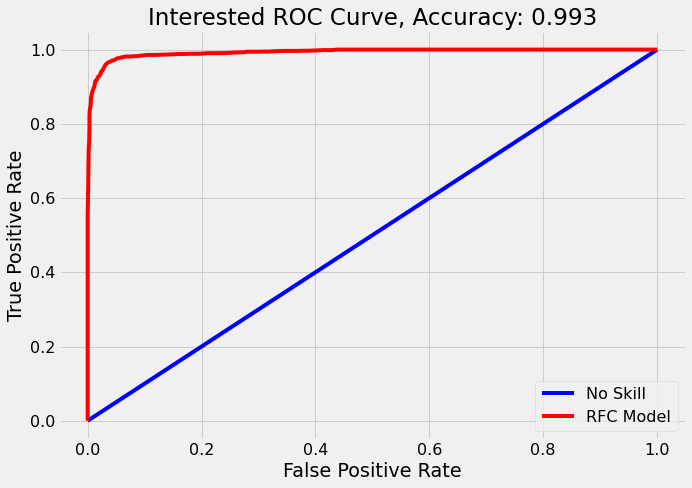

In [26]:
symbol1 = 'Interested'
plt.rcParams['font.size'] = 16
plt.figure(figsize=(10,7))

# No Skill Line Data
base_fpr, base_tpr, _ = roc_curve(y1_test
                                  , [1 for _ in range(len(y1_test))]
                                 ) 

# Model Data
model_fpr, model_tpr, _ = roc_curve(y1_test
                                    , y1_probs
                                   )

plt.plot(base_fpr
         , base_tpr
         , 'b'
         , label='No Skill'
        )

plt.plot(model_fpr
         , model_tpr
         , 'r'
         , label='RFC Model'
        )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{symbol1} ROC Curve, Accuracy: {round(roc_score1, 3)}')
plt.legend();

In [27]:
roc_score2 = roc_auc_score(y2_test
                          , y2_probs
                         )
roc_score2

1.0

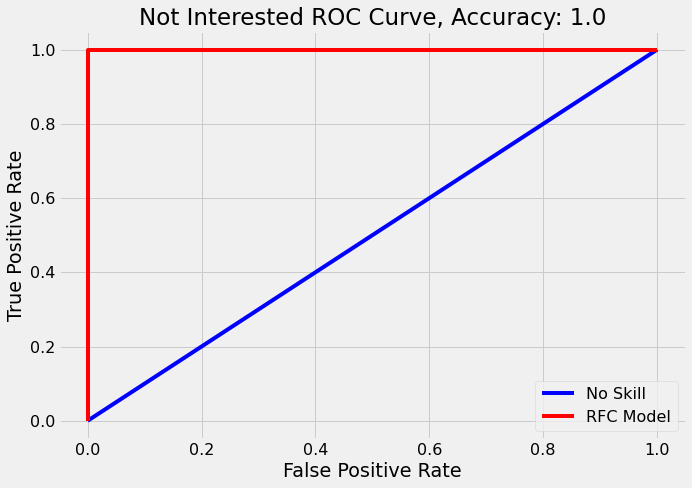

In [28]:
symbol2 = 'Not Interested'
plt.rcParams['font.size'] = 16
plt.figure(figsize=(10,7))

# No Skill Line Data
base_fpr, base_tpr, _ = roc_curve(y2_test
                                  , [1 for _ in range(len(y2_test))]
                                 ) 

# Model Data
model_fpr, model_tpr, _ = roc_curve(y2_test
                                    , y2_probs
                                   )

plt.plot(base_fpr
         , base_tpr
         , 'b'
         , label='No Skill'
        )

plt.plot(model_fpr
         , model_tpr
         , 'r'
         , label='RFC Model'
        )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{symbol2} ROC Curve, Accuracy: {round(roc_score2, 3)}')
plt.legend();

#### Precision Recall Curve

In [29]:
# Precision Recall Data
rf_prec, rf_recall, _ = precision_recall_curve(y1_test
                                             , y1_probs
                                            )

auc_score1 = auc(rf_recall, rf_prec)
auc_score1

0.9934178720436074

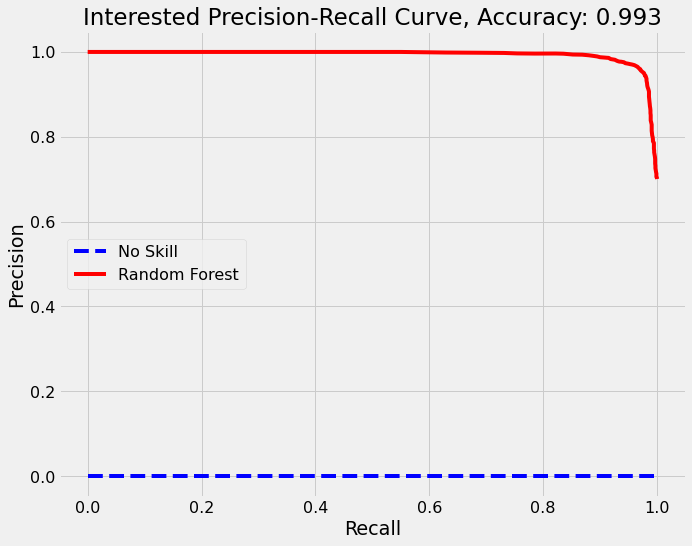

In [30]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10, 8)



# No Skill Line
plt.plot([0, 0]
         , linestyle = '--'
         , color = 'b'
         , label = 'No Skill'
        )

# PR Line
plt.plot(rf_recall
         , rf_prec
         , color = 'r'
         , label = 'Random Forest'
        )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'{symbol1} Precision-Recall Curve, Accuracy: {round(auc_score1, 3)}')
plt.legend(loc='center left');

In [31]:
# Precision Recall Data
rf_prec, rf_recall, _ = precision_recall_curve(y2_test
                                             , y2_probs
                                            )

auc_score2 = auc(rf_recall, rf_prec)
auc_score2

1.0

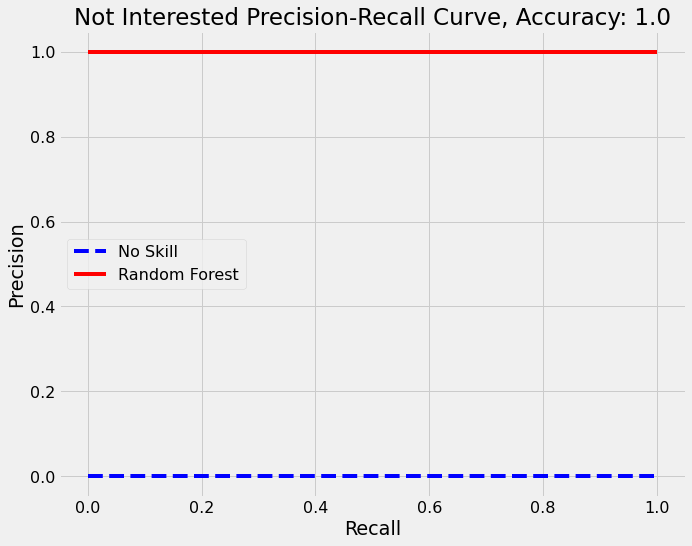

In [32]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10, 8)



# No Skill Line
plt.plot([0, 0]
         , linestyle = '--'
         , color = 'b'
         , label = 'No Skill'
        )

# PR Line
plt.plot(rf_recall
         , rf_prec
         , color = 'r'
         , label = 'Random Forest'
        )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'{symbol2} Precision-Recall Curve, Accuracy: {round(auc_score2, 3)}')
plt.legend(loc='center left');

### Make Predictions

In [33]:
test_df.columns

Index(['user', 'event', 'invited', 'timestamp'], dtype='object')

In [34]:
test_df.loc[:, 'timestamp'] = pd.to_datetime(test_df.timestamp).map(dt.datetime.toordinal)

In [35]:
test_df_rfc1 = test_df.copy()
test_df_rfc2 = test_df.copy()
test_df['interested'] = rfc1.predict(test_df_rfc1)
test_df['not_interested'] = rfc2.predict(test_df_rfc2)

In [36]:
test_df.sample(5)

,user,event,invited,timestamp,interested,not_interested
6279,2664817652,2529072432,0,734778,1,0
2530,1027602768,771676713,0,734799,1,0
695,237595480,798216299,1,734710,0,0
498,182290053,2529072432,0,734802,0,0
3731,1548827068,776270146,0,734787,0,0
